<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week9/alchol_sales_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [53]:
# URL에서 Alcohol Sales CSV 데이터 로드
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/Alcohol_Sales.csv"
# 'DATE' 컬럼을 파싱하고 인덱스로 설정
df = pd.read_csv(url, parse_dates=['DATE'], index_col='DATE')

# 단변량이므로 'S4248SM144NCEN' 컬럼만 사용
data_raw = df['S4248SM144NCEN'].values.astype(float)
data_raw

array([ 3459.,  3458.,  4002.,  4564.,  4221.,  4529.,  4466.,  4137.,
        4126.,  4259.,  4240.,  4936.,  3031.,  3261.,  4160.,  4377.,
        4307.,  4696.,  4458.,  4457.,  4364.,  4236.,  4500.,  4974.,
        3075.,  3377.,  4443.,  4261.,  4460.,  4985.,  4324.,  4719.,
        4374.,  4248.,  4784.,  4971.,  3370.,  3484.,  4269.,  3994.,
        4715.,  4974.,  4223.,  5000.,  4235.,  4554.,  4851.,  4826.,
        3699.,  3983.,  4262.,  4619.,  5219.,  4836.,  4941.,  5062.,
        4365.,  5012.,  4850.,  5097.,  3758.,  3825.,  4454.,  4635.,
        5210.,  5057.,  5231.,  5034.,  4970.,  5342.,  4831.,  5965.,
        3796.,  4019.,  4898.,  5090.,  5237.,  5447.,  5435.,  5107.,
        5515.,  5583.,  5346.,  6286.,  4032.,  4435.,  5479.,  5483.,
        5587.,  6176.,  5621.,  5889.,  5828.,  5849.,  6180.,  6771.,
        4243.,  4952.,  6008.,  5353.,  6435.,  6673.,  5636.,  6630.,
        5887.,  6322.,  6520.,  6678.,  5082.,  5216.,  5893.,  5894.,
      

In [54]:
# -------------------------------------
# 2. Train / Test 분리 및 스케일링
# -------------------------------------

# 8:2 비율로 분리
split_ratio = 0.8
split_index = int(len(data_raw) * split_ratio)

# 훈련용/테스트용 원본 데이터 분리
train_raw = data_raw[:split_index]
test_raw = data_raw[split_index:] # (시각화 및 참고용)

print(f"Total data: {len(data_raw)}, Train points: {len(train_raw)}, Test points (raw): {len(test_raw)}")

# 스케일러 1개 준비 (단변량이므로)
scaler = MinMaxScaler(feature_range=(0, 1))

# (중요) 훈련 데이터(train_raw) 기준으로만 fit
# .reshape(-1, 1)는 1D array를 2D array로 변환
scaler.fit(train_raw.reshape(-1, 1))

# 전체 데이터를 스케일링
data_scaled = scaler.transform(data_raw.reshape(-1, 1)).flatten()

Total data: 325, Train points: 260, Test points (raw): 65


In [55]:
# -------------------------------------
# 3. 슬라이딩 윈도우 생성
# -------------------------------------
WINDOW_SIZE = 12 # 6개월치를 보고 7개월째 예측

def create_sequences(data, window_size): # (단변량으로 수정)
    sequences = []
    labels = []
    if len(data) <= window_size:
        print("Warning: Data length is too small for window size.")
        return [], []

    for i in range(len(data) - window_size):
        seq = data[i:(i + window_size)]
        label = data[i + window_size]
        sequences.append(seq)
        labels.append(label)
    # X: (N, window_size), y: (N,)
    return np.array(sequences), np.array(labels)

# Train 윈도우 생성
train_scaled_data = data_scaled[:split_index]
X, y = create_sequences(train_scaled_data, WINDOW_SIZE)

# Test 윈도우 생성
# (중요) 훈련 마지막 지점(split_index)에서 윈도우 크기만큼 뺀 지점부터 시작
test_start_index = split_index - WINDOW_SIZE
test_scaled_data = data_scaled[test_start_index:]
X_test_seq, y_test_seq = create_sequences(test_scaled_data, WINDOW_SIZE)

# test_size는 실제 생성된 y_test의 개수
test_size = len(y_test_seq)
print(f"Actual test sequences generated: {test_size}")

Actual test sequences generated: 65


In [56]:
# PyTorch 텐서로 변환
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1) # [N, 1]
X_test = torch.tensor(X_test_seq, dtype=torch.float32)
y_test = torch.tensor(y_test_seq, dtype=torch.float32).view(-1, 1) # [N, 1]

print(f"Total data points: {len(data_raw)}")
print(f"Train sequence shape (X, y): {X_train.shape}, {y_train.shape}")
print(f"Test sequence shape (X, y): {X_test.shape}, {y_test.shape}")
# y_test의 샘플 수가 test_size(계산된 값)와 일치하는지 확인
assert len(y_test) == test_size, "Test set size mismatch!"

Total data points: 325
Train sequence shape (X, y): torch.Size([248, 12]), torch.Size([248, 1])
Test sequence shape (X, y): torch.Size([65, 12]), torch.Size([65, 1])


In [57]:
# -------------------------------------
# 4. PyTorch Dataset 및 DataLoader
# -------------------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        # X가 [N, 6] -> [N, 6, 1] (input_dim=1 추가)
        self.X = X.unsqueeze(2)
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [58]:
# -------------------------------------
# 5. 모델 정의 (RNN, LSTM)
# -------------------------------------
# Hyperparameters
INPUT_DIM = 1    # !! 변경 !! 피처 수 (S4248SM144NCEN 1개)
HIDDEN_DIM = 64
NUM_LAYERS = 2
OUTPUT_DIM = 1   # 예측 값 (다음 1개)
DROPOUT = 0.2

class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers,
                          batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim=1)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [59]:
# -------------------------------------
# 6. 훈련 함수
# -------------------------------------
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    print(f"\n--- Training {model.__class__.__name__} ---")
    for epoch in range(num_epochs):
        epoch_loss = 0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            y_pred = model(sequences)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.6f}")


In [60]:
# -------------------------------------
# 7. 모델 훈련 실행
# -------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 200 # 훈련 에포크

# RNN 모델
model_rnn = SimpleRNN(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
criterion = nn.MSELoss()
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=0.001)

train_model(model_rnn, train_loader, criterion, optimizer_rnn, num_epochs=NUM_EPOCHS)

# LSTM 모델
model_lstm = SimpleLSTM(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=0.001)

train_model(model_lstm, train_loader, criterion, optimizer_lstm, num_epochs=NUM_EPOCHS)


--- Training SimpleRNN ---
Epoch [20/200], Loss: 0.010453
Epoch [40/200], Loss: 0.004445
Epoch [60/200], Loss: 0.002595
Epoch [80/200], Loss: 0.001967
Epoch [100/200], Loss: 0.001728
Epoch [120/200], Loss: 0.001821
Epoch [140/200], Loss: 0.002179
Epoch [160/200], Loss: 0.001668
Epoch [180/200], Loss: 0.001684
Epoch [200/200], Loss: 0.001762

--- Training SimpleLSTM ---
Epoch [20/200], Loss: 0.009165
Epoch [40/200], Loss: 0.007967
Epoch [60/200], Loss: 0.007762
Epoch [80/200], Loss: 0.006444
Epoch [100/200], Loss: 0.006271
Epoch [120/200], Loss: 0.006086
Epoch [140/200], Loss: 0.004258
Epoch [160/200], Loss: 0.003146
Epoch [180/200], Loss: 0.002682
Epoch [200/200], Loss: 0.002327



--- 1. Test Set Performance (Original Scale) ---
이것이 실제 모델 성능을 나타내는 의미있는 지표입니다 (예: RMSE=1400).
RNN  - MSE: 1004553.62, RMSE: 1002.27
LSTM - MSE: 830180.69, RMSE: 911.14

--- 2. Test Set Performance (Scaled 0-1) ---
이것은 0-1로 정규화된 값 기준의 오차이며, 실제 성능을 직관적으로 보여주지 않습니다.
RNN  - MSE (scaled): 0.011902, RMSE (scaled): 0.109097
LSTM - MSE (scaled): 0.009836, RMSE (scaled): 0.099177

--- Test Set Predictions (Original Scale) ---
Actuals:
[10494.    11540.    11138.    12709.     8557.     9059.    10055.
 10977.    11792.    11904.    10965.    10981.    10828.    11817.
 10469.999 13309.999  8400.     9062.    10721.999 11107.    11507.999
 12903.999 11869.    11223.999 12022.    11983.    11506.    14183.
  8648.    10321.    12107.    11420.    12238.    13681.    10950.
 12700.    12271.999 11904.999 13015.999 14420.999  9043.    10452.
 12480.999 11491.    13545.    14730.    11416.    13402.    11907.
 12711.    13261.    14264.999  9564.    10415.    12682.999 11919.
 14137.999 14583.    

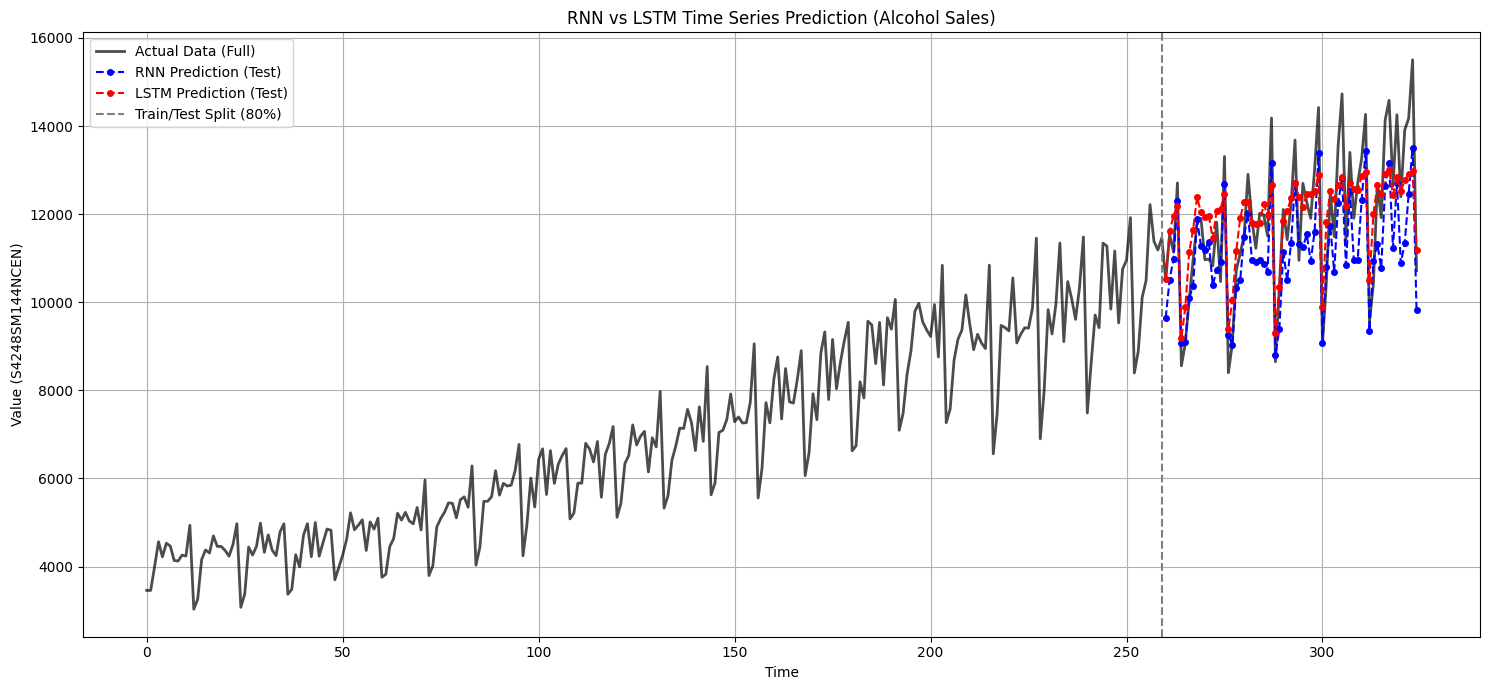

In [61]:
# -------------------------------------
# 8. 평가 및 시각화
# -------------------------------------
def get_predictions(model, loader, scaler): # (단일 scaler로 수정)
    model.eval()
    predictions_scaled_list = []
    actuals_scaled_list = []
    predictions_orig_list = []
    actuals_orig_list = []

    with torch.no_grad():
        for sequences, labels in loader:
            sequences, labels = sequences.to(device), labels.to(device)
            # y_pred_scaled_tensor shape: [batch_size, 1]
            y_pred_scaled_tensor = model(sequences)

            # 1. 스케일링된 값 (0-1) 저장
            y_pred_scaled = y_pred_scaled_tensor.cpu().numpy()
            y_actual_scaled = labels.cpu().numpy()
            predictions_scaled_list.append(y_pred_scaled)
            actuals_scaled_list.append(y_actual_scaled)

            # 2. 원본 스케일 값 저장 (역변환)
            y_pred_orig = scaler.inverse_transform(y_pred_scaled)
            y_actual_orig = scaler.inverse_transform(y_actual_scaled)
            predictions_orig_list.append(y_pred_orig)
            actuals_orig_list.append(y_actual_orig)

    predictions_scaled = np.array(predictions_scaled_list).flatten()
    actuals_scaled = np.array(actuals_scaled_list).flatten()
    predictions_orig = np.array(predictions_orig_list).flatten()
    actuals_orig = np.array(actuals_orig_list).flatten()

    return predictions_scaled, actuals_scaled, predictions_orig, actuals_orig

# (중요) 단일 스케일러(scaler)를 전달
pred_rnn_scaled, actual_rnn_scaled, pred_rnn_orig, actual_rnn_orig = get_predictions(model_rnn, test_loader, scaler)
pred_lstm_scaled, actual_lstm_scaled, pred_lstm_orig, actual_lstm_orig = get_predictions(model_lstm, test_loader, scaler)


# 1. [필수] 원본 스케일로 MSE/RMSE 계산 (의미 있는 성능 지표)
mse_rnn_orig = mean_squared_error(actual_rnn_orig, pred_rnn_orig)
mse_lstm_orig = mean_squared_error(actual_lstm_orig, pred_lstm_orig)
rmse_rnn_orig = np.sqrt(mse_rnn_orig)
rmse_lstm_orig = np.sqrt(mse_lstm_orig)

print("\n--- 1. Test Set Performance (Original Scale) ---")
print("이것이 실제 모델 성능을 나타내는 의미있는 지표입니다 (예: RMSE=1400).")
print(f"RNN  - MSE: {mse_rnn_orig:.2f}, RMSE: {rmse_rnn_orig:.2f}")
print(f"LSTM - MSE: {mse_lstm_orig:.2f}, RMSE: {rmse_lstm_orig:.2f}")


# 2. [참고] 역변환을 안 한 스케일링된 값 (0-1)로 MSE/RMSE 계산
print("\n--- 2. Test Set Performance (Scaled 0-1) ---")
print("이것은 0-1로 정규화된 값 기준의 오차이며, 실제 성능을 직관적으로 보여주지 않습니다.")
mse_rnn_scaled = mean_squared_error(actual_rnn_scaled, pred_rnn_scaled)
mse_lstm_scaled = mean_squared_error(actual_lstm_scaled, pred_lstm_scaled)
rmse_rnn_scaled = np.sqrt(mse_rnn_scaled)
rmse_lstm_scaled = np.sqrt(mse_lstm_scaled)
print(f"RNN  - MSE (scaled): {mse_rnn_scaled:.6f}, RMSE (scaled): {rmse_rnn_scaled:.6f}")
print(f"LSTM - MSE (scaled): {mse_lstm_scaled:.6f}, RMSE (scaled): {rmse_lstm_scaled:.6f}")


print("\n--- Test Set Predictions (Original Scale) ---")
print(f"Actuals:\n{actual_lstm_orig}")
print(f"RNN Preds:\n{pred_rnn_orig}")
print(f"LSTM Preds:\n{pred_lstm_orig}")


# 시각화 (원본 스케일 값(orig)을 사용)
plt.figure(figsize=(15, 7))
plt.title("RNN vs LSTM Time Series Prediction (Alcohol Sales)")
plt.ylabel("Value (S4248SM144NCEN)")
plt.xlabel("Time")
plt.grid(True)

# 1. 전체 원본 데이터 (data_raw)
plt.plot(data_raw, 'k-', label='Actual Data (Full)', linewidth=2.0, alpha=0.7)

# 2. Test 예측 (RNN)
# 예측 시작 인덱스 계산
test_pred_indices = np.arange(len(data_raw) - test_size, len(data_raw))
plt.plot(test_pred_indices, pred_rnn_orig, 'b--o', label='RNN Prediction (Test)', markersize=4)

# 3. Test 예측 (LSTM)
plt.plot(test_pred_indices, pred_lstm_orig, 'r--o', label='LSTM Prediction (Test)', markersize=4)

# 경계선
plt.axvline(x=split_index - 1, c='gray', linestyle='--', label='Train/Test Split (80%)')

plt.legend()
plt.tight_layout()
plt.show()
